In [1]:
!git clone https://github.com/hungvotranchi/ComputerVision.git

Cloning into 'ComputerVision'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 112 (delta 38), reused 101 (delta 30), pack-reused 0
Receiving objects: 100% (112/112), 4.63 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
import os
os.chdir("ComputerVision/ImageClassification")
!sh scripts/download.sh
os.chdir("model")

--2024-03-10 15:57:24--  https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2753340328 (2.6G) [application/x-gzip]
Saving to: 'fgvc-aircraft-2013b.tar.gz'

fgvc-aircraft-2013b 100%[===================>]   2.56G  30.0MB/s    in 93s     

2024-03-10 15:58:58 (28.3 MB/s) - 'fgvc-aircraft-2013b.tar.gz' saved [2753340328/2753340328]

fgvc-aircraft-2013b/
fgvc-aircraft-2013b/vl_tpfp.m
fgvc-aircraft-2013b/README.md
fgvc-aircraft-2013b/example_evaluation.m
fgvc-aircraft-2013b/README.html
fgvc-aircraft-2013b/vl_roc.m
fgvc-aircraft-2013b/vl_pr.m
fgvc-aircraft-2013b/vl_argparse.m
fgvc-aircraft-2013b/evaluation.m
fgvc-aircraft-2013b/data/
fgvc-aircraft-2013b/data/images_test.txt
fgvc-aircraft-2013b/data/images_train.txt
fgvc-aircraft-2013b/data/images_manu

In [3]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn


import sys
sys.path.append("..")
from src.load_data import load_fgvc
from src.preprocess import transform_VGGModel
from src.plotting import imshow
from model.ResNet import ResNet, ResidualBlock, Bottleneck
from src.train_predict import train, test_classification

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
batch_size = 128

train_set, test_set = load_fgvc(transform_VGGModel())
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, \
                                               shuffle = True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, \
                                               shuffle = True, num_workers = 2)

In [6]:
classes = train_set.classes

In [7]:
classes

['707-320',
 '727-200',
 '737-200',
 '737-300',
 '737-400',
 '737-500',
 '737-600',
 '737-700',
 '737-800',
 '737-900',
 '747-100',
 '747-200',
 '747-300',
 '747-400',
 '757-200',
 '757-300',
 '767-200',
 '767-300',
 '767-400',
 '777-200',
 '777-300',
 'A300B4',
 'A310',
 'A318',
 'A319',
 'A320',
 'A321',
 'A330-200',
 'A330-300',
 'A340-200',
 'A340-300',
 'A340-500',
 'A340-600',
 'A380',
 'ATR-42',
 'ATR-72',
 'An-12',
 'BAE 146-200',
 'BAE 146-300',
 'BAE-125',
 'Beechcraft 1900',
 'Boeing 717',
 'C-130',
 'C-47',
 'CRJ-200',
 'CRJ-700',
 'CRJ-900',
 'Cessna 172',
 'Cessna 208',
 'Cessna 525',
 'Cessna 560',
 'Challenger 600',
 'DC-10',
 'DC-3',
 'DC-6',
 'DC-8',
 'DC-9-30',
 'DH-82',
 'DHC-1',
 'DHC-6',
 'DHC-8-100',
 'DHC-8-300',
 'DR-400',
 'Dornier 328',
 'E-170',
 'E-190',
 'E-195',
 'EMB-120',
 'ERJ 135',
 'ERJ 145',
 'Embraer Legacy 600',
 'Eurofighter Typhoon',
 'F-16A/B',
 'F/A-18',
 'Falcon 2000',
 'Falcon 900',
 'Fokker 100',
 'Fokker 50',
 'Fokker 70',
 'Global Express

Training

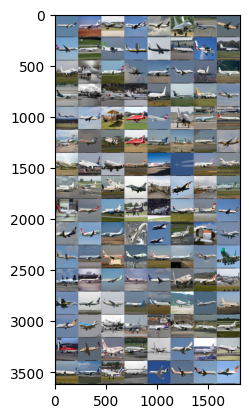

<generator object <genexpr> at 0x78a8612d7e60>


In [8]:
dataiter = iter(train_dataloader)
img, labels = next(dataiter)

imshow(torchvision.utils.make_grid(img))
print(" ".join(f'{classes[labels[j]]}') for j in range(batch_size))


In [9]:
img.shape

torch.Size([128, 3, 224, 224])

ResNet50

In [10]:

model = ResNet(block= Bottleneck,num_blocks=[3, 4, 6, 3], num_classes= len(classes))

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
torch.cuda.empty_cache()

In [12]:
train(num_loops= 20, criterion= criterion, optim= optimizer, model= model, \
      train_dataloader= train_dataloader, device= device, path = "ResNet50_fgcvAircraft.pth")

Finished Training


In [14]:
import gc
# Collect garbage
gc.collect()

# Additionally, for CUDA, you can empty the cache to free unused memory
torch.cuda.empty_cache()

In [15]:
model_pred = ResNet(block= Bottleneck,num_blocks=[3, 4, 6, 3], num_classes= len(classes))
model_pred.load_state_dict(torch.load("ResNet50_fgcvAircraft.pth"))

<All keys matched successfully>

In [16]:
model_pred.to(device)
test_classification(model= model_pred, test_dataloader= test_dataloader, \
                    device= device, classes= classes)
del model_pred

Accuracy of the network in the test dataset: 7 %
Accuracy for class 707-320: 9.090909090909092
Accuracy for class 727-200: 0.0
Accuracy for class 737-200: 0.0
Accuracy for class 737-300: 0.0
Accuracy for class 737-400: 0.0
Accuracy for class 737-500: 0.0
Accuracy for class 737-600: 3.0303030303030303
Accuracy for class 737-700: 0.0
Accuracy for class 737-800: 0.0
Accuracy for class 737-900: 0.0
Accuracy for class 747-100: 0.0
Accuracy for class 747-200: 0.0
Accuracy for class 747-300: 0.0
Accuracy for class 747-400: 0.0
Accuracy for class 757-200: 12.121212121212121
Accuracy for class 757-300: 12.121212121212121
Accuracy for class 767-200: 0.0
Accuracy for class 767-300: 3.0303030303030303
Accuracy for class 767-400: 9.090909090909092
Accuracy for class 777-200: 0.0
Accuracy for class 777-300: 0.0
Accuracy for class A300B4: 0.0
Accuracy for class A310: 0.0
Accuracy for class A318: 0.0
Accuracy for class A319: 21.21212121212121
Accuracy for class A320: 0.0
Accuracy for class A321: 0.0
A

In [17]:
import gc
# Collect garbage
gc.collect()

# Additionally, for CUDA, you can empty the cache to free unused memory
torch.cuda.empty_cache()

In [18]:
from torchvision.models import resnet50

models_pretrained = resnet50(pretrained = True)

    
models_pretrained.fc.out_features = len(classes)  # Get the number of input features of the first layer

# Check the modified model architecture
print(models_pretrained)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(models_pretrained.parameters(), lr=0.001, momentum=0.9)

models_pretrained.to(device)

train(num_loops= 100, criterion= criterion, optim= optimizer, model= models_pretrained, \
      train_dataloader= train_dataloader, device= device, path = "ResNet50_fgcvAircraft.pth")

Finished Training


In [20]:
import gc
# Collect garbage
gc.collect()

# Additionally, for CUDA, you can empty the cache to free unused memory
torch.cuda.empty_cache()

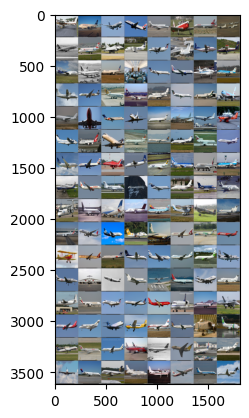

Ground truth:  Cessna 172 A310 A330-300 E-170 Cessna 560 DHC-1 MD-11 An-12 L-1011 Fokker 70 Eurofighter Typhoon Dornier 328 EMB-120 Il-76 An-12 DHC-6 767-300 L-1011 767-400 A340-500 CRJ-700 767-200 PA-28 Fokker 70 ATR-42 777-300 727-200 A319 Cessna 560 ERJ 135 Global Express 767-200 A300B4 737-200 MD-87 Falcon 900 MD-90 A300B4 707-320 PA-28 Dornier 328 A380 CRJ-900 MD-11 A340-600 ERJ 135 Yak-42 727-200 737-700 777-200 Hawk T1 Fokker 50 Fokker 100 737-300 A340-500 Fokker 70 PA-28 737-900 Challenger 600 F/A-18 Global Express Falcon 2000 Challenger 600 BAE 146-200 DHC-8-300 737-200 A321 BAE 146-200 747-400 Cessna 172 Spitfire Yak-42 A340-500 777-300 737-200 DHC-8-100 DC-6 777-200 Boeing 717 MD-80 DH-82 777-300 MD-87 DHC-8-300 767-200 747-200 737-800 Fokker 50 Metroliner Il-76 747-100 Challenger 600 DHC-6 737-400 747-100 Beechcraft 1900 Fokker 50 A340-500 ERJ 135 767-400 A330-200 ERJ 145 DC-9-30 F/A-18 757-200 BAE-125 Boeing 717 Cessna 208 A319 E-195 Tornado 737-700 E-190 CRJ-200 A321 737-

In [21]:
model_pred = models_pretrained
model_pred.load_state_dict(torch.load("ResNet50_fgcvAircraft.pth"))
dataiter = iter(test_dataloader)
img, labels = next(dataiter)
model_pred.to('cpu')
_, predicts = torch.max(model_pred(img), 1)


imshow(torchvision.utils.make_grid(img))
print("Ground truth: ", " ".join(f"{classes[labels[j]]}" for j in range(batch_size)))
print("Predict: ", " ".join(f"{classes[predicts[j]]}" for j in range(batch_size)))




In [22]:
model_pred.to(device)
test_classification(model= model_pred, test_dataloader= test_dataloader, \
                    device= device, classes= classes)

Accuracy of the network in the test dataset: 40 %
Accuracy for class 707-320: 27.272727272727273
Accuracy for class 727-200: 20.58823529411765
Accuracy for class 737-200: 24.242424242424242
Accuracy for class 737-300: 24.242424242424242
Accuracy for class 737-400: 11.764705882352942
Accuracy for class 737-500: 27.272727272727273
Accuracy for class 737-600: 33.333333333333336
Accuracy for class 737-700: 29.41176470588235
Accuracy for class 737-800: 27.272727272727273
Accuracy for class 737-900: 21.21212121212121
Accuracy for class 747-100: 38.23529411764706
Accuracy for class 747-200: 24.242424242424242
Accuracy for class 747-300: 15.151515151515152
Accuracy for class 747-400: 8.823529411764707
Accuracy for class 757-200: 6.0606060606060606
Accuracy for class 757-300: 54.54545454545455
Accuracy for class 767-200: 23.529411764705884
Accuracy for class 767-300: 12.121212121212121
Accuracy for class 767-400: 66.66666666666667
Accuracy for class 777-200: 26.470588235294116
Accuracy for clas